<h1 align="center">Volume 1: Facial Recognition.</h1>

    Cody Kesler
    321
    11/27/2018

In [3]:
import os
import numpy as np
from imageio import imread
from matplotlib import pyplot as plt
from scipy import linalg as la

### Helper Functions

In [4]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))


In [5]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    plt.imshow(np.reshape(image,(m,n)), cmap="gray")
    plt.show();
    

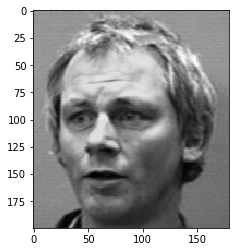

In [6]:
# Get the faces
faces = get_faces()
# print(faces[:,0])
#disply one of the pages
show(faces[:,0])

In [7]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        self.F = get_faces(path)
        self.mu = np.mean(self.F, axis=1)
        # Broadcast subtraction over the COLUMNS.
        # Refer students to the NumPy Visual Guide for help.
        self.Fbar = self.F - np.vstack(self.mu)
        

        self.U,v,d = la.svd(self.Fbar, full_matrices=False)


    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        return self.U[:,:s].T @ A


    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        Fhat = self.project(self.Fbar, s)
        ghat = self.project(g-self.mu, s)
        return np.argmin(np.linalg.norm(Fhat - np.vstack(ghat), axis=0))


    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        j = self.find_nearest(image, s)
        match = self.F[:,j]

        plt.subplot(121)
        plt.title("Input Image")
        show(image, m, n)
        
        plt.subplot(122)
        plt.title("Closest Match")
        show(match, m, n)
        
        plt.show()
        

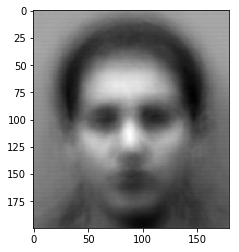

In [8]:
#Show the mean face
# set facial rec object
fr = FacialRec()
# show the average of all the faces
show(fr.mu)

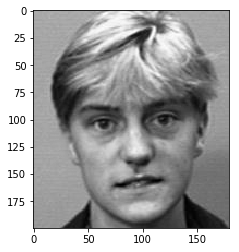

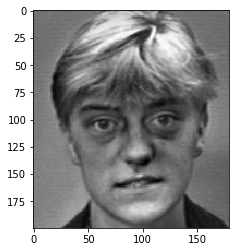

In [9]:
# display a face
show(faces[:,50])
# display a face shifted by the average face
shifted = faces[:,50] - fr.mu
show(shifted)


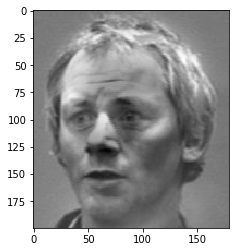

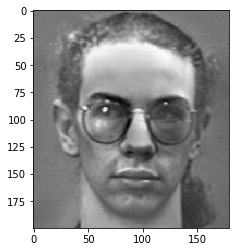

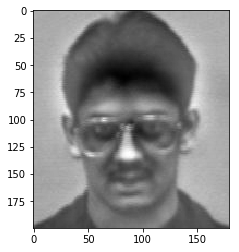

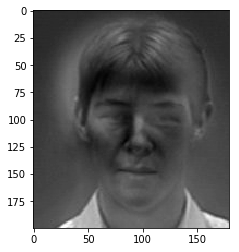

In [10]:
# Show 4 eigen faces 
for i in np.arange(0,120,30):
    show(fr.Fbar[:,i])

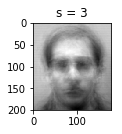

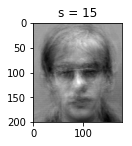

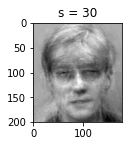

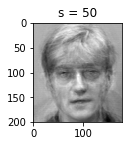

In [11]:
image = fr.Fbar[:,50]

#values of s to iterate over
s_vals = [3,15,30,50]

#rows and columns for subplots
cols = len(s_vals)//2
rows = cols

#create bottom margin for subplots
plt.subplots_adjust(hspace=.5)

for i, s in enumerate(s_vals):
    plt.subplot(cols, rows, i+1)
    plt.title("s = " + str(s))
    #project image onto s thus getting
    #the weights for reconstruction
    projection = fr.project(image, s)
    reconstruction = fr.U[:,:s] @ projection + fr.mu
    show(reconstruction)

In [12]:
# Test
print(fr.find_nearest(fr.F[:,50]))


50


In [13]:
def sample_faces(num_faces, path="./faces94"):
    # Get the list of possible images.
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)
    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, num_faces, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

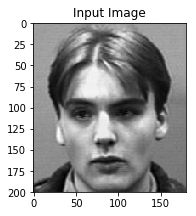

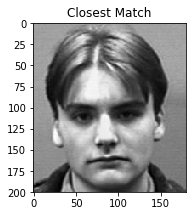

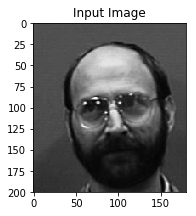

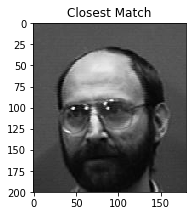

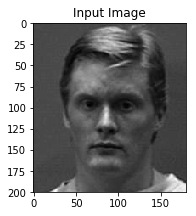

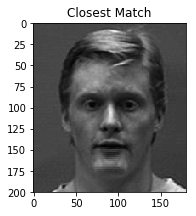

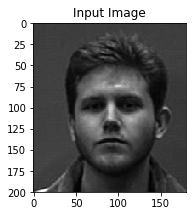

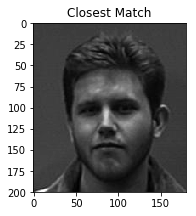

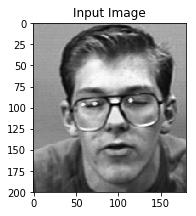

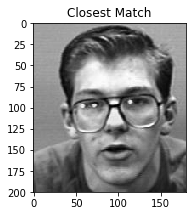

In [14]:
# Show 5 matches
for face in sample_faces(5):
    fr.match(face)